In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import MinMaxScaler # to normalize 
from scipy.stats import shapiro, anderson, probplot
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# Load the data
purchase_data = pd.read_csv('purchase_data.csv',low_memory=False)
#used to suppress the warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Cleaning/pre-processing, Feature Engineering

In [5]:
# Check for missing values
print(purchase_data.isnull().sum())

COMPANY_CODE               0
SUPPLIER_CODE              0
INVOICE_ID                 0
INVOICE_DATE            8830
SUPPLIER_PRODUCT_ID        2
RESTURANT_PRODUCT_ID       0
COMPANY_NAME               0
SUPPLIER_NAME              0
SUPPLIER_PRODUCT           0
RESTURANT_PRODUCT          0
PROD_UNIT_PRICE            0
PROD_QTY                 154
TOTAL_AMOUNT               0
Cmp_DtGerencial            0
dtype: int64


In [6]:
# Check duplicates
print(purchase_data.duplicated().sum())

29910


In [7]:
# Convert the invoice_date column to datetime
purchase_data['INVOICE_DATE'] = pd.to_datetime(purchase_data['INVOICE_DATE'], errors='coerce')

In [8]:
min_date = purchase_data['INVOICE_DATE'].min()
max_date = purchase_data['INVOICE_DATE'].max()
print(f"Data collected from {min_date} to {max_date}")

Data collected from 2014-01-31 00:00:00 to 2024-02-26 00:00:00


In [9]:
# Identify missing dates
missing_dates_count = purchase_data['INVOICE_DATE'].isnull().sum()

In [10]:
# Total number of records 
total_records_count = len(purchase_data)
# Calculate the percentage of missing dates 
missing_percentage = (missing_dates_count / total_records_count) * 100
print(f"Total missing invoice dates: {missing_dates_count}")
print(f"Total records: {total_records_count}")
print(f"Percentage of missing invoice dates: {missing_percentage:.2f}%")

Total missing invoice dates: 8830
Total records: 524809
Percentage of missing invoice dates: 1.68%


# Imputing missing dates

We impute missing dates using the median value of the available dates. This approach provides a robust estimate of the central date, minimizing the impact of any outliers or skew in the data. The median is preferred over the mean or mode for dates, as it accurately reflects a typical time point without being influenced by extreme values.

This imputation method ensures that missing dates are filled with a value representative of the dataset's overall distribution, improving data completeness without introducing bias.

In [12]:
# Handle missing data
median_date = purchase_data['INVOICE_DATE'].median()  #here i have used the median inputation methods. other ML Methods can be explored too
purchase_data['INVOICE_DATE'].fillna(median_date, inplace=True) # filled the missing date with median date

In [13]:
# Create a flag for imputed data
purchase_data['imputed_invoice_date'] = purchase_data['INVOICE_DATE'].isnull().astype(int)

In [14]:
print(f"Total missing invoice dates: {missing_dates_count}")
print(f"Missing dates imputed with median date: {median_date}")

Total missing invoice dates: 8830
Missing dates imputed with median date: 2022-01-13 00:00:00


In [15]:
purchase_data['INVOICE_DATE_NUM'] = purchase_data['INVOICE_DATE'].astype(int) / 1e9  # Convert to seconds since epoch

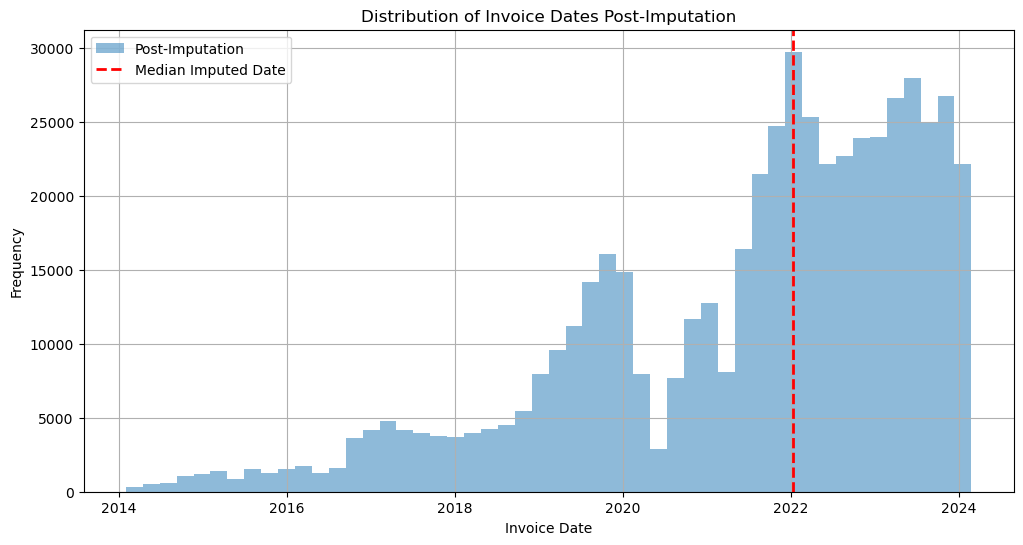

In [16]:
# distribution graph
plt.figure(figsize=(12, 6))
purchase_data['INVOICE_DATE'].hist(bins=50, alpha=0.5, label='Post-Imputation')
plt.axvline(median_date, color='r', linestyle='dashed', linewidth=2, label='Median Imputed Date')
plt.legend()
plt.title('Distribution of Invoice Dates Post-Imputation')
plt.xlabel('Invoice Date')
plt.ylabel('Frequency')
plt.show()

# Encoding categorical data

#Label encoding is used to convert categorical text data into numerical values that machine learning models can process. Many algorithms require numeric input and cannot handle non-numeric data, so encoding transforms categories into integers. Label encoding is especially useful for categorical features that don’t have a natural order

#Works well with tree-based models like Decision Trees and Random Forests, which treat the encoded integers as separate categories without assuming order.

In [17]:
# Applied LabelEncoder to categorical features to convert them into numerical feature so that model can read them
def label_encode_ids(df, columns):
    label_encoder = LabelEncoder()
    for col in columns:
        df[col + '_CODE'] = label_encoder.fit_transform(df[col])
    return df

In [18]:
# before doing the encoding convert all the codes to strings for uniform data type 
purchase_data['COMPANY_CODE'] = purchase_data['COMPANY_CODE'].astype(str)
purchase_data['SUPPLIER_CODE'] = purchase_data['SUPPLIER_CODE'].astype(str)
purchase_data['SUPPLIER_PRODUCT_ID'] = purchase_data['SUPPLIER_PRODUCT_ID'].astype(str)

In [19]:
# Apply label encoding to ids of company, supplier, and item
purchase_data = label_encode_ids(purchase_data, ['COMPANY_CODE', 'SUPPLIER_CODE', 'SUPPLIER_PRODUCT_ID'])

In [20]:
# Added new features from invoice date (part of feature engineering)
purchase_data['year'] = purchase_data['INVOICE_DATE'].dt.year
purchase_data['month'] = purchase_data['INVOICE_DATE'].dt.month
purchase_data['day'] = purchase_data['INVOICE_DATE'].dt.day
purchase_data['day_of_week'] = purchase_data['INVOICE_DATE'].dt.dayofweek

# Check for missing values
print(purchase_data.isnull().sum())

COMPANY_CODE                  0
SUPPLIER_CODE                 0
INVOICE_ID                    0
INVOICE_DATE                  0
SUPPLIER_PRODUCT_ID           0
RESTURANT_PRODUCT_ID          0
COMPANY_NAME                  0
SUPPLIER_NAME                 0
SUPPLIER_PRODUCT              0
RESTURANT_PRODUCT             0
PROD_UNIT_PRICE               0
PROD_QTY                    154
TOTAL_AMOUNT                  0
Cmp_DtGerencial               0
imputed_invoice_date          0
INVOICE_DATE_NUM              0
COMPANY_CODE_CODE             0
SUPPLIER_CODE_CODE            0
SUPPLIER_PRODUCT_ID_CODE      0
year                          0
month                         0
day                           0
day_of_week                   0
dtype: int64



# UNIVARIANT ANALYSIS - PURCHASE PRICE DISTRIBUTION

In [25]:
purchase_data = purchase_data[purchase_data['TOTAL_AMOUNT'] > 0]

In [26]:
scaler = MinMaxScaler()
# transform the prices to a range of 0 to 1. Scaling can  help in identifying outliers more effectively.
purchase_data['normalized_purchase_price'] = scaler.fit_transform(purchase_data[['TOTAL_AMOUNT']])

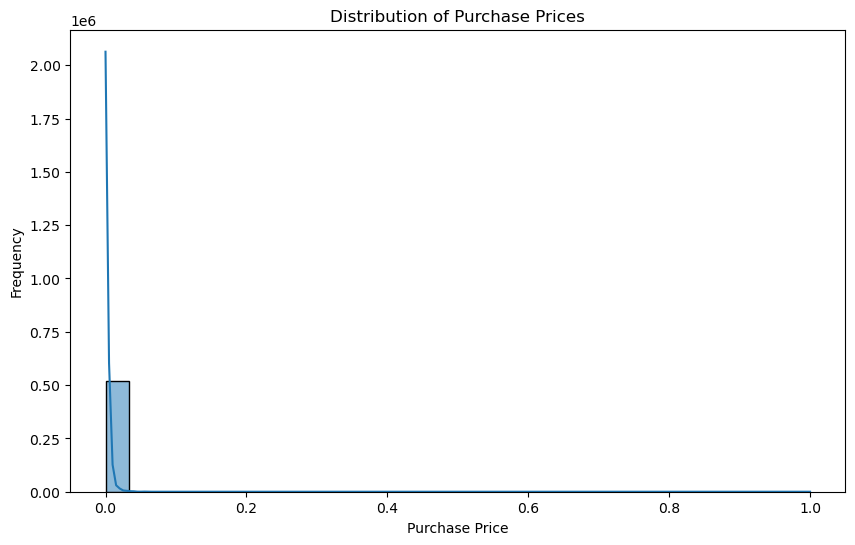

In [27]:
# Histogram of purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['normalized_purchase_price'], bins=30, kde=True)
plt.title('Distribution of Purchase Prices')
plt.xlabel('Purchase Price')
plt.ylabel('Frequency')

# Save the plot as an image file
#save_path = '/Users/ashutoshkumarsonu/Downloads/purchase_price_distribution.png'
#plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Use bbox_inches to avoid cropping issues

plt.show()




the original data is highly right skewed and does not follow a normal distribution. that's why we are going to perform the log transformation to reduce the skewness

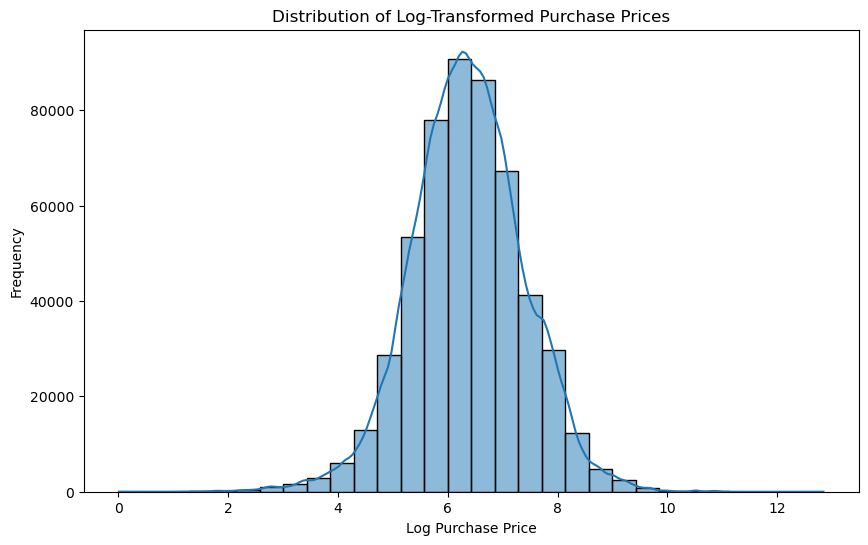

In [28]:
# Log transform the purchase prices
purchase_data['log_purchase_price'] = np.log1p(purchase_data['TOTAL_AMOUNT'])
# Plot the distribution of log-transformed purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['log_purchase_price'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Purchase Prices')
plt.xlabel('Log Purchase Price')
plt.ylabel('Frequency')

# Save the plot as an image file
#save_path = '/Users/ashutoshkumarsonu/Downloads/log_transformed_price_distribution.png'
#plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Use bbox_inches to avoid cropping issues


plt.show()

Text(0.5, 1.0, 'Q-Q Plot of Log-Transformed Data')

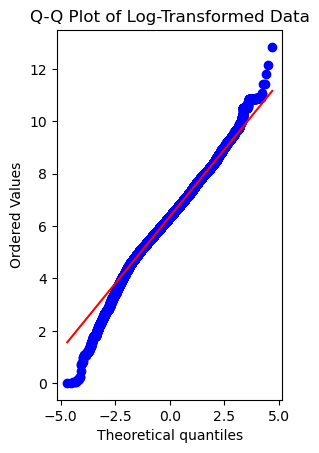

In [29]:
# Q-Q Plot
plt.subplot(1, 2, 2)
probplot(purchase_data['log_purchase_price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')

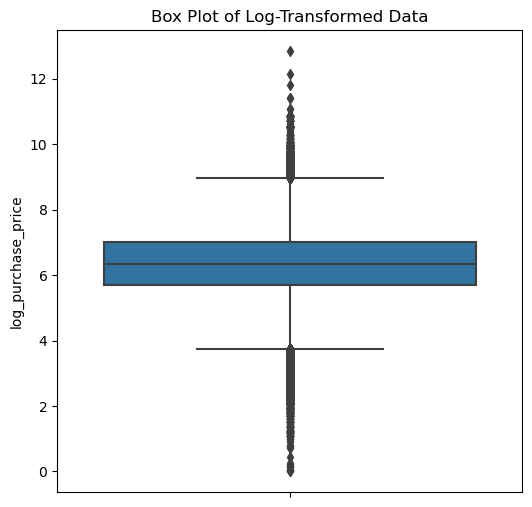

In [30]:
# Box Plot
plt.figure(figsize=(6, 6))
sns.boxplot(y=purchase_data['log_purchase_price'])
plt.title('Box Plot of Log-Transformed Data')
plt.show()

As checked earlier there were no null values in total amount column
checked if log transformed total amount data has the null values in it because the presence of zero or negative values in the original data can result in null (NaN) values in the transformed column  

In [31]:
print(purchase_data['log_purchase_price'].isnull().sum())
print(np.isinf(purchase_data['log_purchase_price']).sum())

0
0


on debugg found that: after doing the log tranformation we are getting the null values thats because When applying a log transformation, the presence of zero or negative values in the original data can result in null (NaN) values in the transformed column. This is because the logarithm of zero or a negative number is undefined in the real number domain

considering it to be the case of item returned, this could not be relevent to our price prediction model.thats why we have filtered such data above.

# UNIT PRICE DISTRIBUTION 

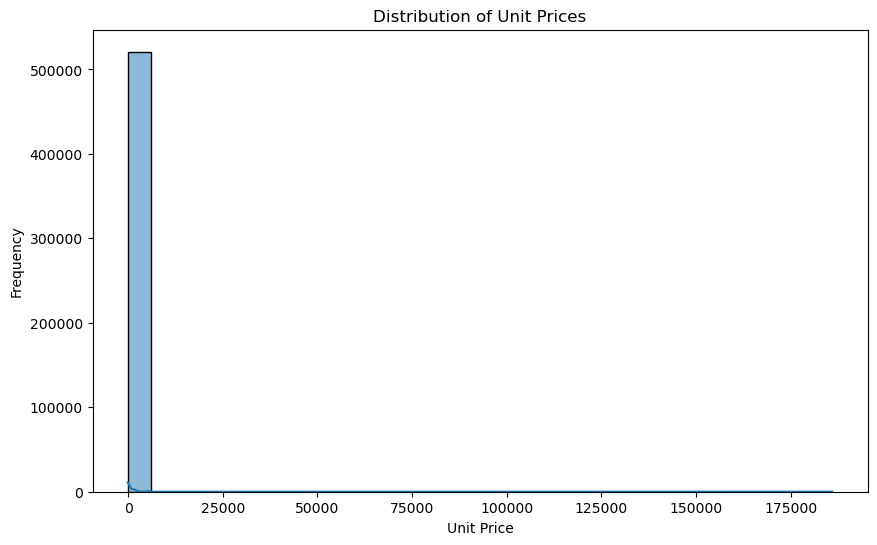

In [32]:
# Histogram of purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['PROD_UNIT_PRICE'], bins=30, kde=True)
plt.title('Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

In [33]:
purchase_data = purchase_data[purchase_data['PROD_UNIT_PRICE'] > 0]

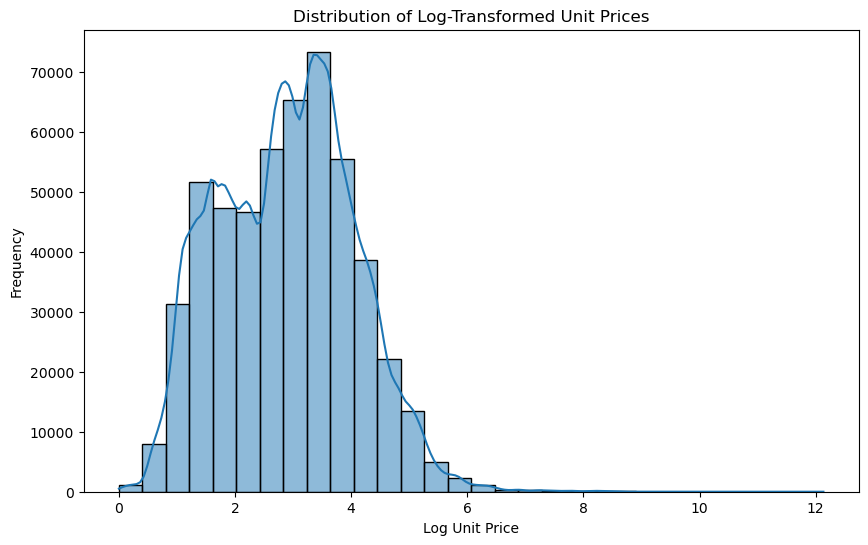

In [34]:
# Log transform the unit prices
purchase_data['log_prod_unit_price'] = np.log1p(purchase_data['PROD_UNIT_PRICE'])

# Plot the distribution of log-transformed purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['log_prod_unit_price'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Unit Prices')
plt.xlabel('Log Unit Price')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Q-Q Plot of Log-Transformed Data')

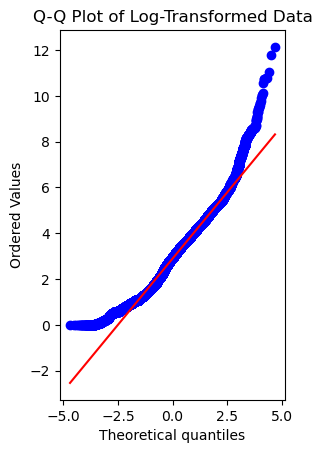

In [35]:
# Q-Q Plot
plt.subplot(1, 2, 2)
probplot(purchase_data['log_prod_unit_price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')

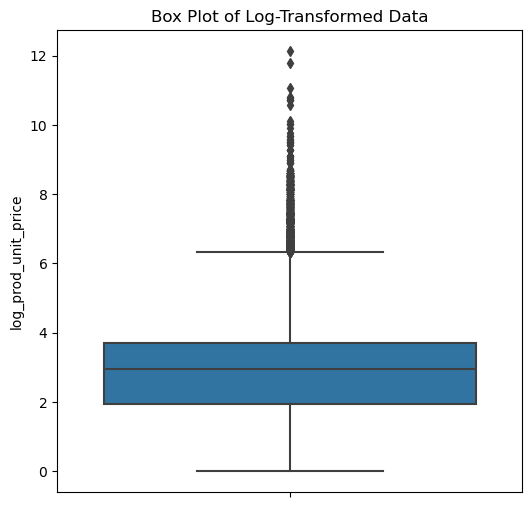

In [36]:
# Box Plot
plt.figure(figsize=(6, 6))
sns.boxplot(y=purchase_data['log_prod_unit_price'])
plt.title('Box Plot of Log-Transformed Data')
plt.show()

# PROD QTY DISTRIBUTION

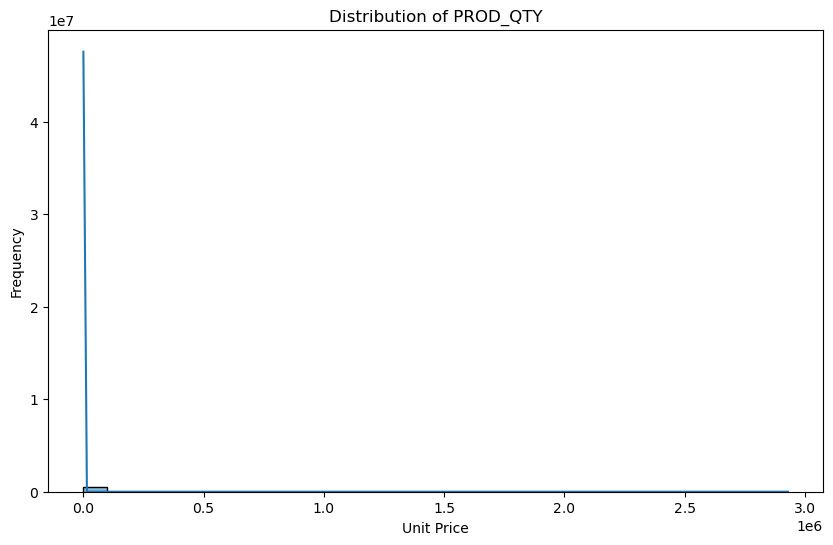

In [37]:
# Histogram of purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['PROD_QTY'], bins=30, kde=True)
plt.title('Distribution of PROD_QTY')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

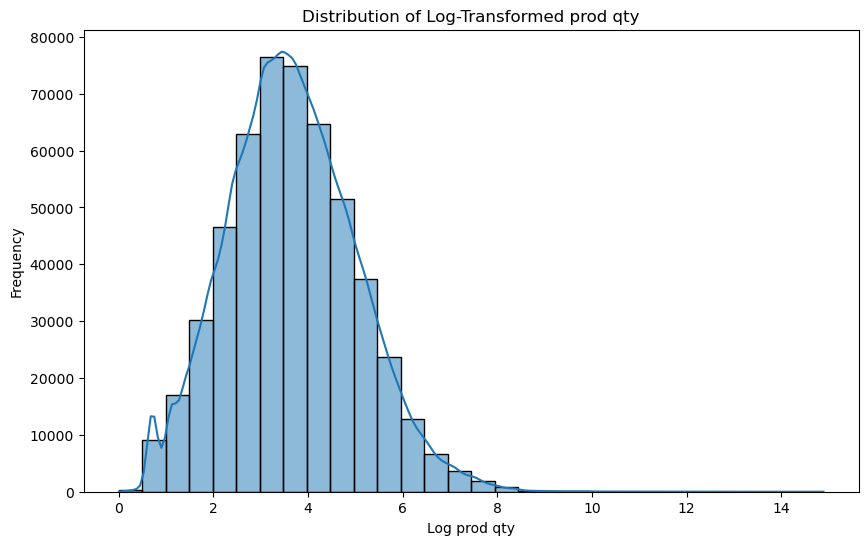

In [38]:
# Log transform the unit prices
purchase_data['log_prod_qty'] = np.log1p(purchase_data['PROD_QTY'])

# Plot the distribution of log-transformed purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['log_prod_qty'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed prod qty')
plt.xlabel('Log prod qty')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Q-Q Plot of Log-Transformed Data')

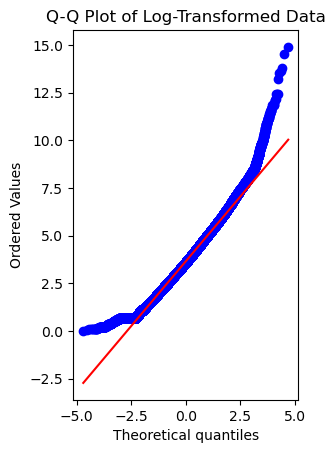

In [39]:
# Q-Q Plot
plt.subplot(1, 2, 2)
probplot(purchase_data['log_prod_qty'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')

In [40]:
purchase_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'INVOICE_DATE_NUM', 'COMPANY_CODE_CODE',
       'SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month',
       'day', 'day_of_week', 'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty'],
      dtype='object')

Insights in data like 
1. Total purchase over time
2. Total Purchases Over Time by Company
3. Percentage of Companies Buying Below and Above Average Price for an item
4. Focused analysis on percentage of Companies Buying Below and Above Average Price for an item at monthly level.

# EXPLORATORY DATA ANALYSIS

# 1. Total purchases Over time

In [35]:
# Unique counts for categorical columns
print(purchase_data['SUPPLIER_NAME'].nunique())
print(purchase_data['SUPPLIER_PRODUCT'].nunique())
print(purchase_data['COMPANY_NAME'].nunique())

2695
52186
142


In [36]:
purchase_data['YearMonth'] = purchase_data['INVOICE_DATE'].dt.to_period('M')

In [37]:
# Group by year and month to analyze trends over time
df_monthly = purchase_data.groupby(['YearMonth', 'SUPPLIER_PRODUCT_ID']).agg(
    total_amount=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='sum'),
    avg_unit_price=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='mean')
).reset_index()
df_monthly['YearMonth'] = df_monthly['YearMonth'].dt.to_timestamp()

In [38]:
purchase_data['YearMonth']= purchase_data['YearMonth'].dt.to_timestamp()
# Merge monthly average prices with the original data
purchase_data = purchase_data.merge(df_monthly[['YearMonth', 'SUPPLIER_PRODUCT_ID', 'avg_unit_price']], left_on=['YearMonth', 'SUPPLIER_PRODUCT_ID'], right_on=['YearMonth', 'SUPPLIER_PRODUCT_ID'], suffixes=('', '_monthly'))


In [39]:
purchase_data=purchase_data.rename(columns={'avg_unit_price':'avg_unit_price_monthly'})

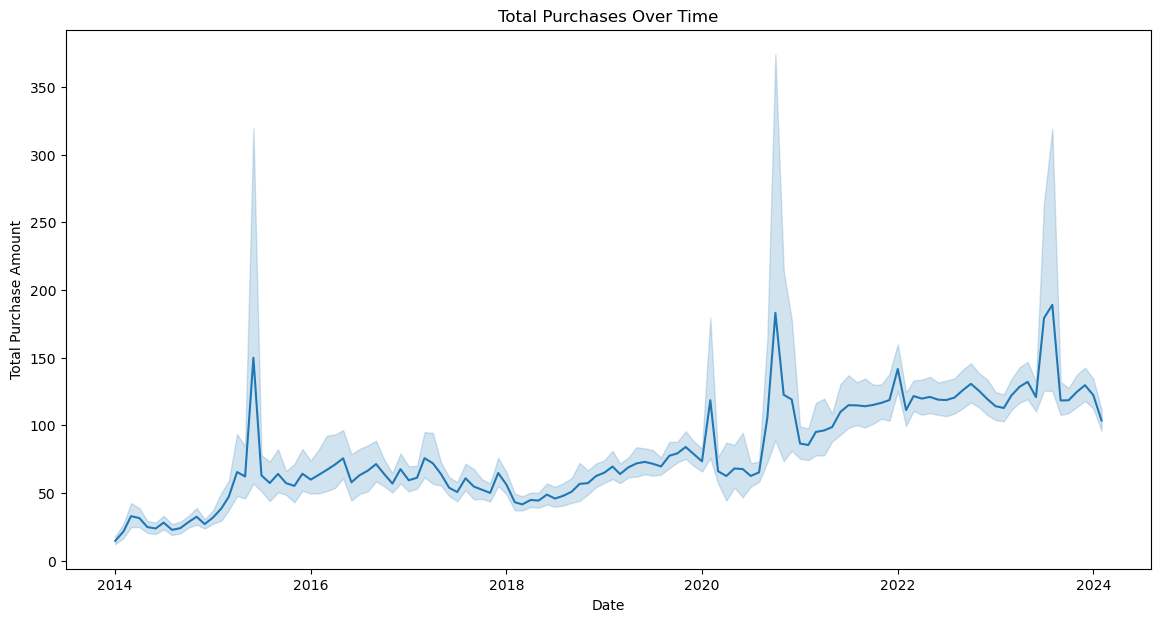

In [40]:
# Plot total purchases over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_monthly, x='YearMonth', y='total_amount')
plt.title('Total Purchases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Purchase Amount')
# Save the plot as an image file
#save_path = '/Users/ashutoshkumarsonu/Downloads/Purchase_trend_over_time.png'
#plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Use bbox_inches to avoid cropping issues

plt.show()

# 2) % of companies buying products above and below the avg unit price for an item and focus on those that are buying above. 

In [41]:
# Calculate overall average prices for each item
average_prices = purchase_data.groupby('SUPPLIER_PRODUCT_ID')['PROD_UNIT_PRICE'].mean().reset_index()
average_prices.columns = ['SUPPLIER_PRODUCT_ID', 'AVERAGE_UNIT_PRICE']

In [42]:
# Merge average prices with the original data
purchase_data = purchase_data.merge(average_prices, on='SUPPLIER_PRODUCT_ID')

In [43]:
# Determine if companies are buying below or above average price
purchase_data['PRICE_COMPARISON'] = np.where(purchase_data['PROD_UNIT_PRICE'] < purchase_data['AVERAGE_UNIT_PRICE'], 'below', 'above')

In [44]:
# Summary of companies buying below and above average price  -- won't required
price_comparison_summary = purchase_data.groupby(['SUPPLIER_PRODUCT_ID', 'PRICE_COMPARISON']).size().unstack().fillna(0)
price_comparison_summary = price_comparison_summary.div(price_comparison_summary.sum(axis=1), axis=0) * 100

In [45]:
# Calculate total revenue for each item and select top 50 best-selling items
#purchase_data['TOTAL_REVENUE'] = purchase_data['PROD_UNIT_PRICE'] * purchase_data['quantity']
top_items = sorted(purchase_data.groupby('SUPPLIER_PRODUCT')['TOTAL_AMOUNT'].sum().nlargest(50).index)

In [46]:
# Filter data to include only top 50 best-selling items
df_top_items = purchase_data[purchase_data['SUPPLIER_PRODUCT'].isin(top_items)]

In [47]:
output = widgets.Output()

In [48]:
# Create interactive filter for top 50 best-selling items
item_selector = widgets.Dropdown(
    options=top_items,
    description='Select Item:',
    value=top_items[0]
)

In [49]:
def update_plot(selected_item):
    with output:
        clear_output(wait=True)
        new_df = df_top_items[df_top_items['SUPPLIER_PRODUCT'] == selected_item]
        new_df_summary = new_df['PRICE_COMPARISON'].value_counts(normalize=True) * 100


        # Define your custom colors
        pie_colors = {'above': 'red', 'below': 'green'}
        
        # First pie chart
        fig1 = go.Figure(data=[
            go.Pie(
                labels=['Above', 'Below'],
                values=new_df_summary.values,
                hole=0.3,
                marker=dict(colors=[pie_colors[label] for label in new_df_summary.index])
            )
        ])
        fig1.update_layout(
            title=f'Percentage of Companies Buying Below and Above Average Price for {selected_item}',
        )
        fig1.show()
        


    
        # Get companies that are buying above average price
        above_avg_companies = new_df[new_df['PRICE_COMPARISON'] == 'above']['COMPANY_NAME'].unique().tolist()


        # Display the companies in a multi-column format
        company_list_html = ''.join([f'<div class="company">{company}</div>' for company in above_avg_companies])
        display(HTML(f"""
            <h3>Companies buying {selected_item} above the average unit price:</h3>
            <div class="company-list">{company_list_html}</div>
            <style>
                .company-list {{
                    display: grid;
                    grid-template-columns: repeat(auto-fill, minmax(150px, 1fr));
                    gap: 10px;
                }}
                .company {{
                    padding: 5px;
                    background-color: #f0f0f0;
                    border-radius: 5px;
                    text-align: center;
                }}
            </style>
        """))





In [50]:
def on_item_change(change):
    update_plot(change['new'])

In [51]:
# Link dropdowns to update plot function for second analysis
item_selector.observe(on_item_change, names='value')

In [52]:

# Display dropdowns and initial plots
display(widgets.HBox([item_selector]))
display(output)
update_plot(item_selector.value)


Output()

# 3. drill down on those buying above and analyse their monthly purchasing behaviour compared to average unit price

In [53]:
# filter data with flag above
above_avg_companies = df_top_items[df_top_items['PRICE_COMPARISON'] == 'above']['COMPANY_NAME'].unique()

In [54]:
# Filter data for these companies
New_filtered_data = df_top_items[df_top_items['COMPANY_NAME'].isin(above_avg_companies)]

In [55]:
New_filtered_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'INVOICE_DATE_NUM', 'COMPANY_CODE_CODE',
       'SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month',
       'day', 'day_of_week', 'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON'],
      dtype='object')

In [56]:
monthly_avg_price = New_filtered_data.groupby(['year','month', 'SUPPLIER_PRODUCT'])['PROD_UNIT_PRICE'].mean().reset_index()
monthly_avg_price.columns = ['year','month', 'SUPPLIER_PRODUCT', 'monthly_avg_unit_price']

In [57]:
# Merge to get monthly average unit price in the filtered data
New_filtered_data = pd.merge(New_filtered_data, monthly_avg_price, on=['year','month', 'SUPPLIER_PRODUCT'])


In [58]:
# Add a column to indicate if the price is above or below the monthly average
New_filtered_data['PRICE_COMPARISON_MONTHLY'] = New_filtered_data.apply(
    lambda row: 'above' if row['PROD_UNIT_PRICE'] > row['monthly_avg_unit_price'] else 'below', axis=1
)

In [59]:
# Extract years for the dropdown selector
years = New_filtered_data['year'].unique()
companies = sorted(New_filtered_data['COMPANY_NAME'].unique())
New_filtered_data['month_name'] = New_filtered_data['INVOICE_DATE'].dt.strftime('%B')

In [60]:
# Widgets and output for second analysis
item_selector_new = widgets.Dropdown(
    options=sorted(New_filtered_data['SUPPLIER_PRODUCT'].unique()),
    description='Item:'
)
year_selector_new = widgets.Dropdown(
    options=years,
    description='Year:'
)
company_selector_new = widgets.Dropdown(
    options=companies,  # This will be updated dynamically based on the first analysis
    description='Company:'
)
output_1 = widgets.Output()

In [61]:
# Update plot function for second analysis
def update_plot_new(selected_item, selected_year, selected_company):
    with output_1:
        clear_output(wait=True)
        #print(f"Second analysis parameters - Item: {selected_item}, Year: {selected_year}, Company: {selected_company}")
        filtered_df = New_filtered_data[(New_filtered_data['SUPPLIER_PRODUCT'] == selected_item) & 
                                    (New_filtered_data['year'] == selected_year) &
                                    (New_filtered_data['COMPANY_NAME'] == selected_company)]

        if filtered_df.empty:
            print("No data available for the selected filters.")
            return
        
        # Group by month to get counts of above/below for each month
        monthly_summary = filtered_df.groupby(['month', 'month_name', 'PRICE_COMPARISON_MONTHLY']).size().unstack(fill_value=0)
        monthly_summary = monthly_summary.sort_index(level='month')
        
        # Prepare data for the bar plot
        fig = go.Figure()
        
        if 'above' in monthly_summary.columns:
            fig.add_trace(go.Bar(
                x=monthly_summary.index.get_level_values('month_name'),
                y=monthly_summary['above'],
                name='Above',
                marker_color='red'
            ))
        if 'below' in monthly_summary.columns:
            fig.add_trace(go.Bar(
                x=monthly_summary.index.get_level_values('month_name'),
                y=monthly_summary['below'],
                name='Below',
                marker_color='green'
            ))
        
        fig.update_layout(
            title=f'Monthly Analysis of {selected_item} for {selected_company} in {selected_year}',
            barmode='group',
            xaxis_title='Month',
            yaxis_title='Number of Transactions',
            legend_title='Comparison'
        )
        
        fig.show()

In [62]:
def on_item_change_2(change):
    update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)

def on_year_change_2(change):
    update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)

def on_company_change_2(change):
    update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)


In [63]:
# Link dropdowns to update plot function for second analysis

item_selector_new.observe(on_item_change_2, names='value')
year_selector_new.observe(on_year_change_2, names='value')
company_selector_new.observe(on_company_change_2, names='value')

# Display dropdowns and initial plot for second analysis
display(widgets.HBox([item_selector_new, year_selector_new,company_selector_new]))
display(output_1)
update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)


Output()

In [64]:
# Summary statistics by supplier
supplier_summary = purchase_data.groupby('SUPPLIER_NAME').agg({
    'TOTAL_AMOUNT': 'sum',
    'PROD_UNIT_PRICE': ['mean', 'std'],
    'PROD_QTY': 'sum'
}).reset_index()

In [65]:
# Summary statistics by company
company_summary = purchase_data.groupby('COMPANY_NAME').agg({
    'TOTAL_AMOUNT': 'sum',
    'PROD_UNIT_PRICE': ['mean', 'std'],
    'PROD_QTY': 'sum'
}).reset_index()

In [66]:
company_summary

COMPANY_NAME TOTAL_AMOUNT PROD_UNIT_PRICE  \
                                                      sum            mean   
0                                        405      5579.80       84.523077   
1                               Abstrato Bar   1137521.92       48.544683   
2                            Aero Vila Cinco  18036444.72       49.258929   
3                              Alfredos 408n  16888029.54       35.435223   
4                              Alfredos 506s   3585761.18       57.073655   
..                                       ...          ...             ...   
137                            Zel GastroPup     59221.63      155.201794   
138                          Zepelim Burguer   1777601.35       11.443193   
139                               Ziriguidum   1707716.87       27.801282   
140                              Zé Torresmo    341730.84       71.809403   
141  xMarzuk Emporio AC 04/02/22 a  30/06/22     13819.43       31.191636   

                     PROD_QTY  
            std           sum  
0      1.719571  6.596751e+01  
1    125.197966  9.900970e+04  
2    139.243606  1.346358e+06  
3     46.195628  9.577415e+05  
4    274.985115  2.379431e+05  
..          ...           ...  
137   93.717663  9.715312e+02  
138   33.028355  4.050611e+05  
139   64.233030  2.905456e+05  
140  372.740016  2.017829e+04  
141   13.869408  4.689392e+02  

[142 rows x 5 columns]

In [67]:
# Identify top suppliers and companies
top_suppliers = purchase_data.groupby('SUPPLIER_NAME')['TOTAL_AMOUNT'].sum().nlargest(10).index
top_companies = purchase_data.groupby('COMPANY_NAME')['TOTAL_AMOUNT'].sum().nlargest(10).index

In [68]:
# Identify top 10 suppliers based on total purchase amount
top_suppliers = purchase_data.groupby('SUPPLIER_NAME')['TOTAL_AMOUNT'].sum().nlargest(10).index

In [69]:
top_suppliers

Index(['Ambev', 'Brasal Refrigerantes S/A', 'SUPER ADEGA',
       'Ambev S.A. - CDD Brasilia', 'ATACADAO S.A.',
       'STO ATACADISTA DE ALIMENTOS EIRELI',
       'GARRA ATACADO E DISTRIBUICAO DE ALIMENTOS LTDA', 'NOBORU HORTIFRUTI',
       'Brasal', 'AMBEV'],
      dtype='object', name='SUPPLIER_NAME')

In [70]:
# Filter data for top 10 suppliers
df_top_suppliers = purchase_data[purchase_data['SUPPLIER_NAME'].isin(top_suppliers)]

In [71]:
# Price variance by supplier and item over time for top suppliers
price_variance_top = df_top_suppliers.groupby(['SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'year']).agg(
    avg_unit_price=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='mean'),
    price_std=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='std')
).reset_index()

In [72]:
price_variance_top

,SUPPLIER_NAME,SUPPLIER_PRODUCT,year,avg_unit_price,price_std
0,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 76,...",2022,76.846333,6.643632
1,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 85,...",2021,67.585000,5.536646
2,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 85,...",2022,80.682500,4.366252
3,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 85,...",2023,85.090000,NaN
4,AMBEV,BECKS LONG NECK 275ML SIX PACK CX04 TRAY INT,2018,77.530000,NaN
...,...,...,...,...,...
12009,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN,2020,36.900000,NaN
12010,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN,2021,40.960000,NaN
12011,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN01UN,2021,42.832000,4.817149
12012,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN01UN,2022,42.425000,3.682232


In [73]:
# Analyze the purchasing patterns of top companies
df_top_companies = purchase_data[purchase_data['COMPANY_NAME'].isin(top_companies)]
df_top_companies

,COMPANY_CODE,SUPPLIER_CODE,INVOICE_ID,INVOICE_DATE,SUPPLIER_PRODUCT_ID,RESTURANT_PRODUCT_ID,COMPANY_NAME,SUPPLIER_NAME,SUPPLIER_PRODUCT,RESTURANT_PRODUCT,...,day,day_of_week,normalized_purchase_price,log_purchase_price,log_prod_unit_price,log_prod_qty,YearMonth,avg_unit_price_monthly,AVERAGE_UNIT_PRICE,PRICE_COMPARISON
2,2113,96,2567,2024-02-24,27,332,Iate - Vila Cinco,TANAPORTA HORTIFRUTI DELIVERY LTDA,AGRIAO,Banana da Terra,...,24,5,0.004961,7.537126,1.798404,5.921871,2024-02-01,8.625556,10.571412,below
3,2113,96,2562,2024-02-23,27,332,Iate - Vila Cinco,TANAPORTA HORTIFRUTI DELIVERY LTDA,AGRIAO,Banana da Terra,...,23,4,0.002673,6.918923,1.798404,5.305504,2024-02-01,8.625556,10.571412,below
4,2113,96,2545,2024-02-22,27,332,Iate - Vila Cinco,TANAPORTA HORTIFRUTI DELIVERY LTDA,AGRIAO,Banana da Terra,...,22,3,0.003555,7.204038,1.798404,5.589631,2024-02-01,8.625556,10.571412,below
10,608,47,6473,2024-02-19,27,379,Shoio,PHD,ALCOOL LIQUIDO HIG 70% JFERES - 1 L,alcool 70,...,19,0,0.002682,6.922624,2.130610,4.924750,2024-02-01,8.625556,10.571412,below
13,595,18,8484,2024-02-16,27,707,Aero Vila Cinco,CIDADE DISTRIBUIDORA,COXA/S.COXA DE FRANGO CG ENVELOP FRIATO,COXA E SOBRECOXA,...,16,4,0.003168,7.088701,2.047693,5.183945,2024-02-01,8.625556,10.571412,below
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520679,595,64,2794,2022-01-13,721,666,Aero Vila Cinco,BSB Vila Cinco,MONTES ALPHA CAB SAUV,MONTES ALPHA CAB SAUV,...,13,3,0.002952,7.018124,4.543020,2.564949,2022-01-01,92.974200,92.974200,above
520680,585,83,3781,2022-01-13,975,1009,BSB Vila Cinco,Aero Vila Cinco,FARINHA PANKO,Farinha de Panko,...,13,3,0.000166,4.153871,2.605382,1.791733,2022-01-01,12.519500,12.519500,above
520681,585,83,3892,2022-01-13,975,1009,BSB Vila Cinco,Aero Vila Cinco,FARINHA PANKO,Farinha de Panko,...,13,3,0.002645,6.908755,2.605353,4.391609,2022-01-01,12.519500,12.519500,above
520682,585,83,4510,2022-01-13,975,1009,BSB Vila Cinco,Aero Vila Cinco,FARINHA PANKO,Farinha de Panko,...,13,3,0.003195,7.097425,2.601660,4.582266,2022-01-01,12.519500,12.519500,below


In [74]:
df_top_companies.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'INVOICE_DATE_NUM', 'COMPANY_CODE_CODE',
       'SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month',
       'day', 'day_of_week', 'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON'],
      dtype='object')

In [75]:
# Aggregate total purchases by company and year
company_purchases_yearly = df_top_companies.groupby(['COMPANY_NAME', 'year'])['TOTAL_AMOUNT'].sum().reset_index()

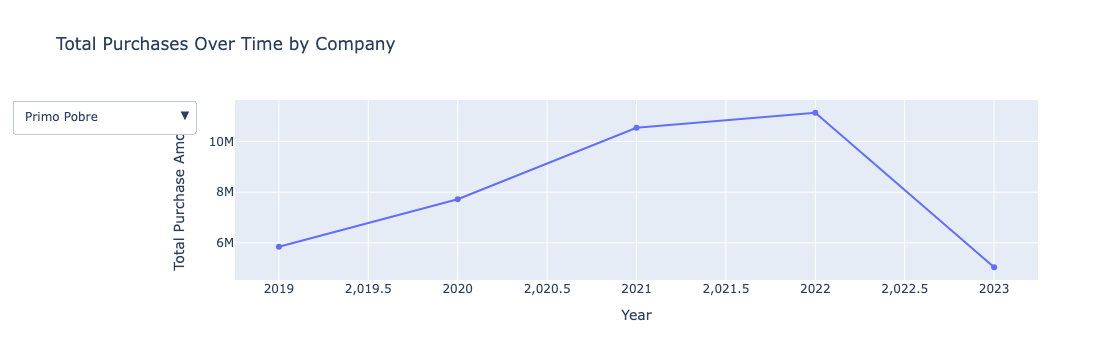

In [76]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to create a figure for a specific company
def create_figure(company):
    filtered_df = company_purchases_yearly[company_purchases_yearly['COMPANY_NAME'] == company]
    fig = px.line(filtered_df, x='year', y='TOTAL_AMOUNT', title=f'Total Purchases Over Time for {company}')
    fig.update_layout(xaxis_title='Year', yaxis_title='Total Purchase Amount')
    return fig

# Create a dropdown menu with Plotly
dropdown_buttons = [
    {
        'label': company,
        'method': 'update',
        'args': [{'visible': [company == comp for comp in top_companies]}]
    }
    for company in top_companies
]

# Create subplots (one for each company initially set to not visible)
fig = make_subplots(rows=1, cols=1)

# Add a trace for each company
for company in top_companies:
    filtered_df = company_purchases_yearly[company_purchases_yearly['COMPANY_NAME'] == company]
    fig.add_trace(
        go.Scatter(x=filtered_df['year'], y=filtered_df['TOTAL_AMOUNT'], mode='lines+markers', name=company),
        row=1, col=1
    )

# Update layout with dropdown menu
fig.update_layout(
    title='Total Purchases Over Time by Company',
    xaxis_title='Year',
    yaxis_title='Total Purchase Amount',
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True
    }]
)

# Initially, show the first company's data only
fig.update_traces(visible=False)
fig.data[0].visible = True




fig.show()

In [77]:
supplier_purchases_yearly = df_top_suppliers.groupby(['SUPPLIER_NAME', 'year'])['PROD_UNIT_PRICE'].sum().reset_index()

In [78]:
supplier_purchases_yearly

,SUPPLIER_NAME,year,PROD_UNIT_PRICE
0,AMBEV,2018,4162.552
1,AMBEV,2019,28764.613
2,AMBEV,2020,19025.281
3,AMBEV,2021,43034.045
4,AMBEV,2022,63989.664
...,...,...,...
59,SUPER ADEGA,2020,61256.091
60,SUPER ADEGA,2021,126647.541
61,SUPER ADEGA,2022,84952.121
62,SUPER ADEGA,2023,39857.285


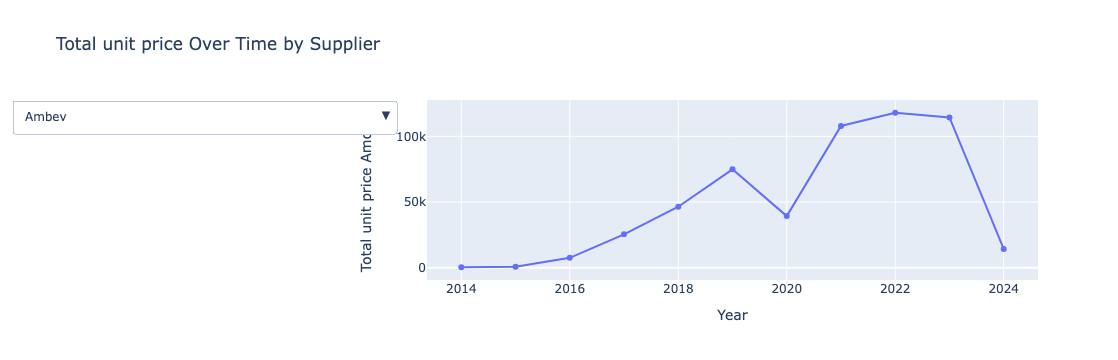

In [79]:
# Function to create a figure for a specific supplier
def create_figure(supplier):
    filtered_df = supplier_purchases_yearly[supplier_purchases_yearly['SUPPLIER_NAME'] == supplier]
    fig = px.line(filtered_df, x='year', y='PROD_UNIT_PRICE', title=f'Total Purchases Over Time for {supplier}')
    fig.update_layout(xaxis_title='Year', yaxis_title='Total unit price')
    return fig

# Create a dropdown menu with Plotly
dropdown_buttons = [
    {
        'label': supplier,
        'method': 'update',
        'args': [{'visible': [supplier == sup for sup in top_suppliers]}]
    }
    for supplier in top_suppliers
]

# Create subplots (one for each supplier initially set to not visible)
fig = make_subplots(rows=1, cols=1)

# Add a trace for each supplier
for supplier in top_suppliers:
    filtered_df = supplier_purchases_yearly[supplier_purchases_yearly['SUPPLIER_NAME'] == supplier]
    fig.add_trace(
        go.Scatter(x=filtered_df['year'], y=filtered_df['PROD_UNIT_PRICE'], mode='lines+markers', name=supplier),
        row=1, col=1
    )

# Update layout with dropdown menu
fig.update_layout(
    title='Total unit price Over Time by Supplier',
    xaxis_title='Year',
    yaxis_title='Total unit price Amount',
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True
    }]
)

# Initially, show the first supplier's data only
fig.update_traces(visible=False)
fig.data[0].visible = True

fig.show()

# Set up for an alert system for effective purchasing efficiency

In [80]:
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet


In [81]:
purchase_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'INVOICE_DATE_NUM', 'COMPANY_CODE_CODE',
       'SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month',
       'day', 'day_of_week', 'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON'],
      dtype='object')

In [82]:
#purchase_data.drop(columns=['OTHER_COMPANIES_AVG_PRICE'], inplace=True)

In [83]:
def calculate_avg_prices(df):
    # Calculate the overall average price for each product
    overall_avg_prices = df.groupby('SUPPLIER_PRODUCT_ID')['PROD_UNIT_PRICE'].mean().reset_index()
    overall_avg_prices.columns = ['SUPPLIER_PRODUCT_ID', 'OVERALL_AVG_PRICE']
    
    # Calculate the sum and count for each item and company
    item_company_stats = df.groupby(['SUPPLIER_PRODUCT_ID', 'COMPANY_CODE'])['PROD_UNIT_PRICE'].agg(['sum', 'count']).reset_index()
    item_company_stats.columns = ['SUPPLIER_PRODUCT_ID', 'COMPANY_CODE', 'COMPANY_SUM_PRICE', 'COMPANY_COUNT']
    
    # Calculate the total sum and count for each item
    total_item_stats = df.groupby('SUPPLIER_PRODUCT_ID')['PROD_UNIT_PRICE'].agg(['sum', 'count']).reset_index()
    total_item_stats.columns = ['SUPPLIER_PRODUCT_ID', 'TOTAL_SUM_PRICE', 'TOTAL_COUNT']
    
    # Merge the dataframes
    merged_stats = pd.merge(item_company_stats, total_item_stats, on='SUPPLIER_PRODUCT_ID')
    
    # Calculate the average price paid by other companies
    merged_stats['OTHER_COMPANIES_SUM_PRICE'] = merged_stats['TOTAL_SUM_PRICE'] - merged_stats['COMPANY_SUM_PRICE']
    merged_stats['OTHER_COMPANIES_COUNT'] = merged_stats['TOTAL_COUNT'] - merged_stats['COMPANY_COUNT']
    merged_stats['OTHER_COMPANIES_AVG_PRICE'] = merged_stats['OTHER_COMPANIES_SUM_PRICE'] / merged_stats['OTHER_COMPANIES_COUNT']

    #print(df.columns)
    
    # Merge back with the original dataframe
    df = pd.merge(df, merged_stats[['SUPPLIER_PRODUCT_ID', 'COMPANY_CODE', 'OTHER_COMPANIES_AVG_PRICE']], on=['SUPPLIER_PRODUCT_ID', 'COMPANY_CODE'], how='left')

    #print(df.columns)
    # Fill NaN values with overall average prices
    #df = pd.merge(df, overall_avg_prices, on='SUPPLIER_PRODUCT_ID', how='left')
    df = df.merge(overall_avg_prices, on='SUPPLIER_PRODUCT_ID', how='left', suffixes=('', '_OVERALL'))
    df['OTHER_COMPANIES_AVG_PRICE'].fillna(df['OVERALL_AVG_PRICE'], inplace=True)
    #print(df.columns)
    # Drop the extra column used for NaN filling
    df.drop(columns=['OVERALL_AVG_PRICE'], inplace=True)
    
    return df

In [84]:
purchase_data = calculate_avg_prices(purchase_data)

In [85]:
# Calculate price discrepancy
purchase_data['PRICE_DISCREPANCY'] = purchase_data['PROD_UNIT_PRICE'] - purchase_data['OTHER_COMPANIES_AVG_PRICE']

In [86]:
# Calculate interaction features
purchase_data['SUPPLIER_ITEM_AVG_PRICE'] = purchase_data.groupby(['SUPPLIER_CODE', 'SUPPLIER_PRODUCT_ID'])['PROD_UNIT_PRICE'].transform('mean')
purchase_data['SUPPLIER_ITEM_COMPANY_COUNT'] = purchase_data.groupby(['SUPPLIER_CODE', 'SUPPLIER_PRODUCT_ID'])['COMPANY_CODE'].transform('nunique')

In [87]:
#purchase_data['log_prod_qty'].
nan_rows = purchase_data[purchase_data['log_prod_qty'].isnull()]

In [88]:
purchase_data['log_prod_qty'].fillna(0, inplace=True)
purchase_data['log_prod_unit_price'].fillna(0, inplace=True)

# Experiments on model selection 

In [89]:
features = ['COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month','day','SUPPLIER_ITEM_AVG_PRICE','SUPPLIER_ITEM_COMPANY_COUNT','log_prod_qty','log_prod_unit_price','AVERAGE_UNIT_PRICE']
X = purchase_data[features]
y = purchase_data['PROD_UNIT_PRICE']

In [90]:
# Check for NaN values in X
nan_columns = X.isna().any()
# Print columns with NaN values
nan_columns_with_nan = nan_columns[nan_columns].index.tolist()
print("Columns with NaN values:", nan_columns_with_nan)

Columns with NaN values: []


In [91]:
# Initial feature selection using Variance Threshold
vt = VarianceThreshold(threshold=0.1)
X_vt = vt.fit_transform(X)

# Further feature selection using SelectKBest
skb = SelectKBest(score_func=f_regression, k='all')  # Adjust 'k' as needed
X_skb = skb.fit_transform(X_vt, y)

# Recursive Feature Elimination (RFE)
model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_skb, y)
selected_features_rfe = X.columns[rfe.get_support()]

# Use feature importance from RandomForest
model.fit(X_skb, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features_importance = [X.columns[i] for i in indices[:10]]

# Combine selected features
combined_features = set(selected_features_rfe) | set(top_features_importance)
print("Combined Selected Features: ", combined_features)

# Use combined selected features for model evaluation
X_selected = X[list(combined_features)]



Combined Selected Features:  {'year', 'SUPPLIER_ITEM_COMPANY_COUNT', 'SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'AVERAGE_UNIT_PRICE', 'SUPPLIER_ITEM_AVG_PRICE', 'month', 'day', 'COMPANY_CODE_CODE', 'log_prod_unit_price'}


In [93]:
features_for_training=list(combined_features)

In [94]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [95]:
# Define the models and hyperparameter grids
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42),
}

In [96]:
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGB': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
  
}

In [97]:
# Evaluate each model
best_models = {}
results = []

for model_name in models:
    print(f"Running RandomizedSearchCV for {model_name}...")
    warnings.filterwarnings("ignore", category=FutureWarning)
    model = models[model_name]
    param_grid = param_grids[model_name]
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = random_search.best_estimator_
    best_models[model_name] = best_model
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'{model_name} - Mean Squared Error: {mse}')
    print(f'{model_name} - Mean Absolute Error: {mae}')
    print('-' * 50)
    
    # Store results for comparison
    results.append({
        'Model': model_name,
        'Best Parameters': random_search.best_params_,
        'MSE': mse,
        'MAE': mae
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


Running RandomizedSearchCV for RandomForest...


/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py

RandomForest - Mean Squared Error: 101698.29929302148
RandomForest - Mean Absolute Error: 1.4518654187980464
--------------------------------------------------
Running RandomizedSearchCV for KNeighbors...


/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be

KNeighbors - Mean Squared Error: 273638.0921344931
KNeighbors - Mean Absolute Error: 7.073906604466027
--------------------------------------------------
Running RandomizedSearchCV for DecisionTree...


/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and 

DecisionTree - Mean Squared Error: 218507.68711096534
DecisionTree - Mean Absolute Error: 2.316642492347872
--------------------------------------------------
Running RandomizedSearchCV for GradientBoosting...


/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be

GradientBoosting - Mean Squared Error: 105636.63417330787
GradientBoosting - Mean Absolute Error: 1.987009018987545
--------------------------------------------------
Running RandomizedSearchCV for XGB...


/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

XGB - Mean Squared Error: 90543.31463968198
XGB - Mean Absolute Error: 7.170323916214514
--------------------------------------------------
              Model                                    Best Parameters  \
0      RandomForest  {'n_estimators': 100, 'min_samples_split': 2, ...   
1        KNeighbors  {'weights': 'distance', 'n_neighbors': 7, 'alg...   
2      DecisionTree  {'min_samples_split': 2, 'min_samples_leaf': 2...   
3  GradientBoosting  {'n_estimators': 200, 'max_depth': 3, 'learnin...   
4               XGB  {'n_estimators': 200, 'max_depth': 3, 'learnin...   

             MSE       MAE  
0  101698.299293  1.451865  
1  273638.092134  7.073907  
2  218507.687111  2.316642  
3  105636.634173  1.987009  
4   90543.314640  7.170324  


In [98]:
# Determine the overall best model based on MSE
best_model_name = results_df.loc[results_df['MSE'].idxmin()]['Model']
overall_best_model = best_models[best_model_name]

print(f'Overall Best Model: {best_model_name}')
print(f'Best Model Parameters: {results_df.loc[results_df["Model"] == best_model_name]["Best Parameters"].values[0]}')
print(f'Best Model MSE: {results_df.loc[results_df["Model"] == best_model_name]["MSE"].values[0]}')
print(f'Best Model MAE: {results_df.loc[results_df["Model"] == best_model_name]["MAE"].values[0]}')

Overall Best Model: XGB
Best Model Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Best Model MSE: 90543.31463968198
Best Model MAE: 7.170323916214514


In [99]:
# Extract results from RandomizedSearchCV for the Gradient Boosting model
gb_random_search = random_search  # Assuming random_search was assigned to the Gradient Boosting model
cv_results = pd.DataFrame(gb_random_search.cv_results_)

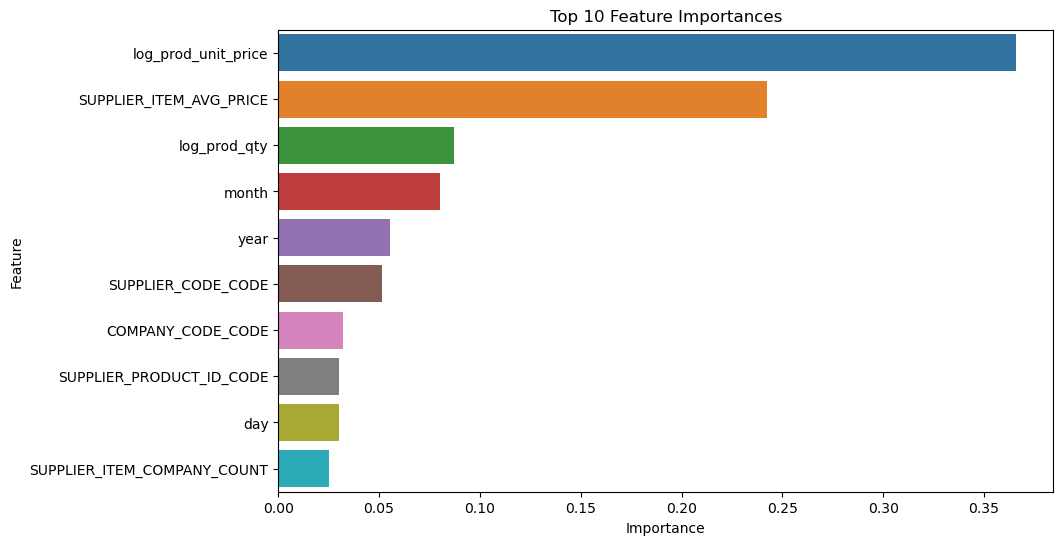

In [100]:
# Extract feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [X.columns[i] for i in indices[:10]]

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:10], y=top_features)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Save the plot as an image file
save_path = '/Users/ashutoshkumarsonu/Downloads/top_feature_importance.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Use bbox_inches to avoid cropping issues



plt.show()

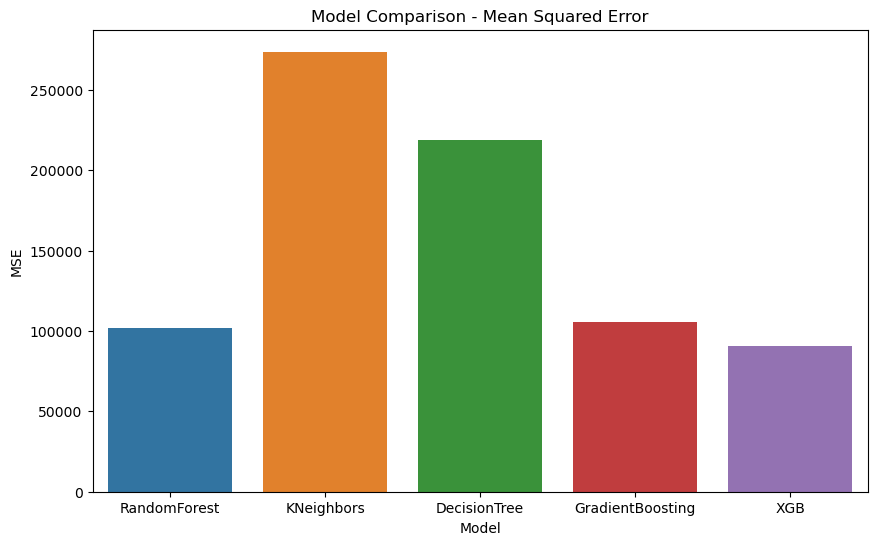

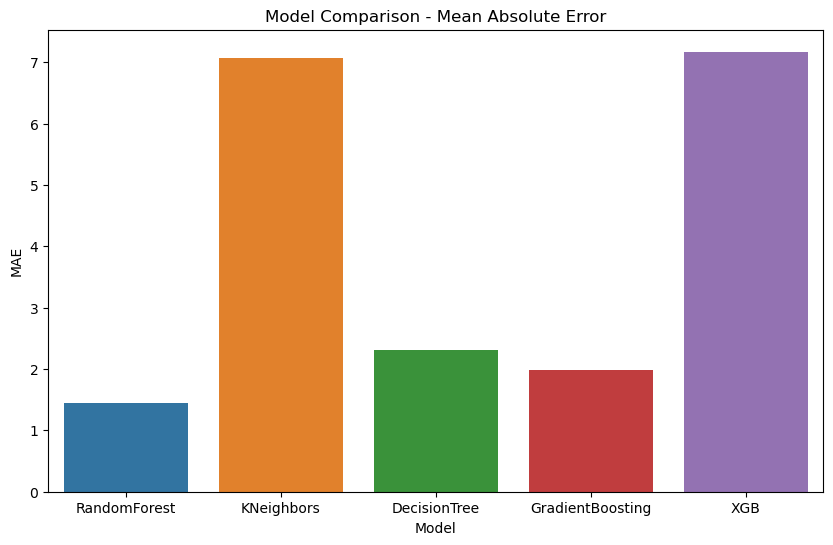

In [101]:
# Plot the results for better visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('Model Comparison - Mean Squared Error')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

In [102]:
# Take out last two months data date to test the setup on

# Determine the most recent invoice date
most_recent_date = purchase_data['INVOICE_DATE'].max()
# Calculate the date two months before the most recent invoice date
two_months_ago = most_recent_date - pd.DateOffset(months=2)
# Filter data for the last two months up to the most recent invoice date
filtered_data = purchase_data[(purchase_data['INVOICE_DATE'] >= two_months_ago) & (purchase_data['INVOICE_DATE'] <= most_recent_date)]


In [111]:
HIGH_SAVING_THRESHOLD_PERCENT = 2  # 20% savings
MEDIUM_SAVING_THRESHOLD_PERCENT = 1  # 10% savings
LOW_SAVING_THRESHOLD_PERCENT =0.1   # 5% savings

In [112]:
# Function to generate flags based on potential savings percentage
def generate_flags(potential_savings_percent):
    if potential_savings_percent >= HIGH_SAVING_THRESHOLD_PERCENT:
        return 'red'
    elif potential_savings_percent >= MEDIUM_SAVING_THRESHOLD_PERCENT:
        return 'yellow'
    elif potential_savings_percent >= LOW_SAVING_THRESHOLD_PERCENT:
        return 'green'
    else:
        return 'none'

In [113]:
# ANSI escape sequences for text colors
class colors:
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    RESET = '\033[0m'  # Reset to default color

In [114]:
def generate_alerts(df, overall_best_model, quantity, features_for_training):

    # Ensure PROD_UNIT_PRICE is included in the DataFrame
    if 'PROD_UNIT_PRICE' not in df.columns:
        raise ValueError("PROD_UNIT_PRICE must be present in the DataFrame for calculating potential savings.")
    # Predict prices using the model
    df['predicted_price'] = overall_best_model.predict(df[features_for_training])
    # Calculate potential savings
    df['potential_savings'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) * quantity
    df['potential_savings_percent'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) / df['predicted_price'] * 100

    #print(df[['potential_savings','PROD_UNIT_PRICE','AVERAGE_UNIT_PRICE', 'OTHER_COMPANIES_AVG_PRICE','predicted_price']])
    # Filter alerts to include only where potential savings are greater than 0 and unit price is higher than predicted price
    alerts = df[(df['potential_savings'] > 0) & (df['PROD_UNIT_PRICE'] > df['predicted_price'])]   
    # Exclude cases where PROD_UNIT_PRICE is equal to predicted_price
    alerts = alerts[alerts['PROD_UNIT_PRICE'] != alerts['predicted_price']]
    #print(alerts)
    
    return alerts

In [115]:
# Function to generate flags based on potential savings percentage
def generate_flags(potential_savings_percent):
    if potential_savings_percent >= HIGH_SAVING_THRESHOLD_PERCENT:
        return 'red'
    elif potential_savings_percent >= MEDIUM_SAVING_THRESHOLD_PERCENT:
        return 'yellow'
    elif potential_savings_percent >= LOW_SAVING_THRESHOLD_PERCENT:
        return 'green'
    else:
        return 'none'

In [116]:
import shutil

# Function to get terminal width
def get_terminal_width():
    return shutil.get_terminal_size().columns

# Function to print bold and centered text
def print_bold_centered(text, width=80):
    bold_text = f"\033[1m{text}\033[0m"
    print(bold_text.center(width))

In [117]:
# Function to generate and display alerts for selected items, quantities, and company
def check_item_savings(company_id, item_quantities, filtered_data, overall_best_model, features_for_training, only_red_alerts=True):
    total_savings = 0
    item_summary = []
    terminal_width = get_terminal_width()  # Get terminal width

    for item_name, quantity in item_quantities.items():
        # Filter data for the specific item and company
        item_data = filtered_data[(filtered_data['SUPPLIER_PRODUCT'] == item_name) & (filtered_data['COMPANY_CODE'] == company_id)]
        
        # Check if item_data is empty
        if item_data.empty:
            print(f"No data found for item {item_name} and company {company_id}.")
            continue
        
        # Generate alerts
        alerts = generate_alerts(item_data, overall_best_model, quantity, features_for_training)
        
        if alerts.empty:
            print(f"No potential savings found for item {item_name} and company {company_id}.")
            continue
        
        # Remove alerts where potential savings is 0 or unit price and predicted price are the same
        alerts = alerts[(alerts['potential_savings'] > 0) & (alerts['PROD_UNIT_PRICE'] != alerts['predicted_price'])]
        
        if alerts.empty:
            print(f"No valid alerts found for item {item_name} and company {company_id}.")
            continue
        
        # Apply flag color filter and filter to only red alerts
        alerts['flag'] = alerts['potential_savings_percent'].apply(generate_flags)
        alerts = alerts[alerts['flag'] == 'red']
        
        # If no red alerts are found, print a message
        if alerts.empty:
            print(f"No red alerts found for item {item_name} and company {company_id}.")
            continue

        # Calculate total potential savings for the item (only considering red alerts)
        item_total_savings = alerts['potential_savings'].sum()
        total_savings += item_total_savings

        # Print total potential savings in bold and centered
        savings_message = f"Total potential savings for item {item_name} and company {company_id}: ${item_total_savings:.2f} with quantity {quantity}"
        print_bold_centered(savings_message, terminal_width)
        
        # Fetch prices for other companies buying at prices lower than your predicted price
        other_companies_data = filtered_data[
            (filtered_data['SUPPLIER_PRODUCT'] == item_name) & 
            (filtered_data['COMPANY_CODE'] != company_id) & 
            (filtered_data['PROD_UNIT_PRICE'] < alerts['predicted_price'].iloc[0])
        ]
        
        # Check if other_companies_data is empty
        if other_companies_data.empty:
            avg_price = np.nan
        else:
            # Calculate average price from other companies
            avg_price = other_companies_data['PROD_UNIT_PRICE'].mean()
        
        # Store summary for the item
        item_summary.append({
            'item_name': item_name,
            'total_savings': item_total_savings,
            'alerts': alerts,
            'avg_price': avg_price
        })
        
        # Print individual alerts with flags, predicted price, average price, and potential savings
        for index, row in alerts.iterrows():
            flag = generate_flags(row['potential_savings_percent'])
            if flag == 'yellow':
                flag_color = colors.YELLOW
            elif flag == 'red':
                flag_color = colors.RED
            else:
                flag_color = colors.RESET
            
            avg_price_display = f"${avg_price:.2f}" if not np.isnan(avg_price) else "N/A"
            print(f"Alert: {flag_color}{row['SUPPLIER_NAME']} selling {row['SUPPLIER_PRODUCT']} to {row['COMPANY_CODE']} at "
                  f"${row['PROD_UNIT_PRICE']:.2f}, which is higher than the predicted price of ${row['predicted_price']:.2f}. "
                  f"Potential savings: ${row['potential_savings']:.2f} ({row['potential_savings_percent']:.2f}%) Flag: {flag}{colors.RESET}"
                  f"\n   Predicted price: ${row['predicted_price']:.2f}"
                  f"\n   Average price from other companies (below predicted price): {avg_price_display}")


In [118]:
# Testing the results 
item_quantities = {
    'CEBOLA': 10,
    'TOMATE LONGA VIDA': 15
}
company_id = '1015'
check_item_savings(company_id, item_quantities, filtered_data, overall_best_model,features_for_training, only_red_alerts=False)

Total potential savings for item CEBOLA and company 1015: $4.84 with quantity 10
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1015 at $6.50, which is higher than the predicted price of $6.26. Potential savings: $2.42 (3.87%) Flag: red
   Predicted price: $6.26
   Average price from other companies (below predicted price): $5.77
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1015 at $6.50, which is higher than the predicted price of $6.26. Potential savings: $2.42 (3.87%) Flag: red
   Predicted price: $6.26
   Average price from other companies (below predicted price): $5.77
No potential savings found for item TOMATE LONGA VIDA and company 1015.


/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_41106/1342840513.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_41106/1342840513.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_41106/1342840513.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 